# Laboratorio 6 - Data Science

* Mónica Salvatierra 22249
* Derek Arreaga 22537

**Importación de Librerías**

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

import numpy as np
from collections import Counter


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

1. **Importación de Datos**

In [ ]:
print('Cargando los datos...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

Cargando los datos...


In [ ]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [42]:
y_train[0]

np.int64(1)

In [ ]:
# Promedio de largo de reseñas
total_lenght = 0
for x in X_train:
    total_lenght += len(x)
print(f'Promedio de largo de reseñas: {total_lenght/len(X_train)}')

# Reseña más corta
min_len = len(X_train[0])
for x in X_train:
    if len(x) < min_len:
        min_len = len(x)
print(f'Largo de reseña más corta: {min_len}')

Promedio de largo de reseñas: 238.71364
Largo de reseña más corta: 11


2. **Preprocesamiento**

Limitar reseñas para lograr una longitud uniforme

In [ ]:
maxlen = 80
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)

Extracción de ``features`` adicionales:
* Longitud de la crítica
* Proporción de palabras positivas/negativas

In [ ]:


# Obtener el diccionario de palabras de IMDB
word_index = imdb.get_word_index()

# Diccionarios de palabras positivas y negativas (puedes expandirlos)
positive_words = {'good', 'great', 'awesome', 'excellent', 'fantastic', 'wonderful', 'love', 'amazing', 'brilliant', 'enjoyable'}
negative_words = {'bad', 'terrible', 'awful', 'horrible', 'disappointing', 'poor', 'hate', 'worst', 'boring', 'dreadful', 'fuck', 'shit', 'idiot', 'stupid', 'mediocre', 'boring', 'bored', 'asleep', 'waste', 'senseless', 'suck', 'sucks'}

# Mapear palabras positivas/negativas a sus índices
positive_indices = {word_index.get(word) + 3 for word in positive_words if word_index.get(word) is not None}
negative_indices = {word_index.get(word) + 3 for word in negative_words if word_index.get(word) is not None}

# Función para extraer características de una reseña codificada
def extract_features_from_encoded(encoded_reviews):
    features = []
    for review in encoded_reviews:
        # Filtrar tokens no nulos (ignorar padding)
        valid_tokens = [token for token in review if token > 0]
        
        # 1. Longitud de la reseña (antes del padding)
        review_length = len(valid_tokens)
        
        # 2. Proporción de palabras positivas y negativas
        token_counts = Counter(valid_tokens)
        pos_count = sum(token_counts[idx] for idx in positive_indices if idx in token_counts)
        neg_count = sum(token_counts[idx] for idx in negative_indices if idx in token_counts)
        total_tokens = review_length if review_length > 0 else 1  # Evitar división por cero
        pos_ratio = pos_count / total_tokens
        neg_ratio = neg_count / total_tokens
        
        # 3. Conteo de tokens únicos
        unique_tokens = len(set(valid_tokens))
        
        # 4. Proporción de tokens repetidos (redundancia léxica)
        repeated_tokens = sum(count for count in token_counts.values() if count > 1)
        repeat_ratio = repeated_tokens / total_tokens if total_tokens > 0 else 0
        
        # 5. Proporción de tokens raros (índices > num_words/2, asumiendo palabras menos comunes)
        rare_threshold = 50000 // 2  # Mitad del vocabulario
        rare_count = sum(1 for token in valid_tokens if token > rare_threshold)
        rare_ratio = rare_count / total_tokens if total_tokens > 0 else 0
        
        # Guardar características
        features.append({
            'length': review_length,
            'positive_ratio': pos_ratio,
            'negative_ratio': neg_ratio,
            'unique_tokens': unique_tokens,
            'repeat_ratio': repeat_ratio,
            'rare_ratio': rare_ratio
        })
    
    return features

# Extraer características para el conjunto de entrenamiento
print('Extrayendo características de los datos codificados...')
train_features = extract_features_from_encoded(X_train)

# Convertir a un array numpy
feature_names = ['length', 'positive_ratio', 'negative_ratio', 'unique_tokens', 'repeat_ratio', 'rare_ratio']
train_features_array = np.array([[f[name] for name in feature_names] for f in train_features])
print('Características extraídas correctamente.')

Extrayendo características de los datos codificados...
Características extraídas correctamente.


Mostrar las careacterísticas de la primera reseña

In [46]:
print(train_features[0])

if y_train[0] == 1:
    print('La reseña es positiva.')
else:
    print('La reseña es negativa.')

{'length': 80, 'positive_ratio': 0.025, 'negative_ratio': 0.0, 'unique_tokens': 58, 'repeat_ratio': 0.4375, 'rare_ratio': 0.0125}
La reseña es positiva.


Estadísticas generales de las nuevas ``features``:

In [47]:

for i, name in enumerate(feature_names):
    print(f'{name}: media={np.mean(train_features_array[:, i]):.4f}, std={np.std(train_features_array[:, i]):.4f}')

# Porcentaje de reseñas positivas y negativas
positive_count = sum(y_train)
negative_count = len(y_train) - positive_count
print(f'Procentaje de reseñas positivas: {positive_count/len(y_train)*100:.2f}%')
print(f'Procentaje de reseñas negativas: {negative_count/len(y_train)*100:.2f}%')

length: media=78.3894, std=6.7216
positive_ratio: media=0.0084, std=0.0121
negative_ratio: media=0.0056, std=0.0112
unique_tokens: media=60.2248, std=6.2032
repeat_ratio: media=0.3679, std=0.0811
rare_ratio: media=0.0122, std=0.0155
Procentaje de reseñas positivas: 50.00%
Procentaje de reseñas negativas: 50.00%


3. **Modelo**

Características extraídas para el conjunto de prueba.
Características normalizadas.


c:\Users\drkfa\U\DS\LAB6-DS\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 80, 128)   │  6,400,000 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 80, 256)   │    263,168 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 80, 256)   │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    394,240 │ dropout_8[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 262)       │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     33,664 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,099,393 (27.08 MB)

 Trainable params: 7,099,393 (27.08 MB)

 Non-trainable params: 0 (0.00 B)

Entrenando el modelo...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 370ms/step - accuracy: 0.7814 - loss: 0.4577 - val_accuracy: 0.8438 - val_loss: 0.3555
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 385ms/step - accuracy: 0.9124 - loss: 0.2300 - val_accuracy: 0.8298 - val_loss: 0.3794
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 387ms/step - accuracy: 0.9649 - loss: 0.1050 - val_accuracy: 0.8264 - val_loss: 0.6052
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 409ms/step - accuracy: 0.9849 - loss: 0.0449 - val_accuracy: 0.8226 - val_loss: 0.7274
Evaluando el modelo...
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step
Accuracy: 0.8392
Precision: 0.8401
Recall: 0.8378
F1-Score: 0.8390


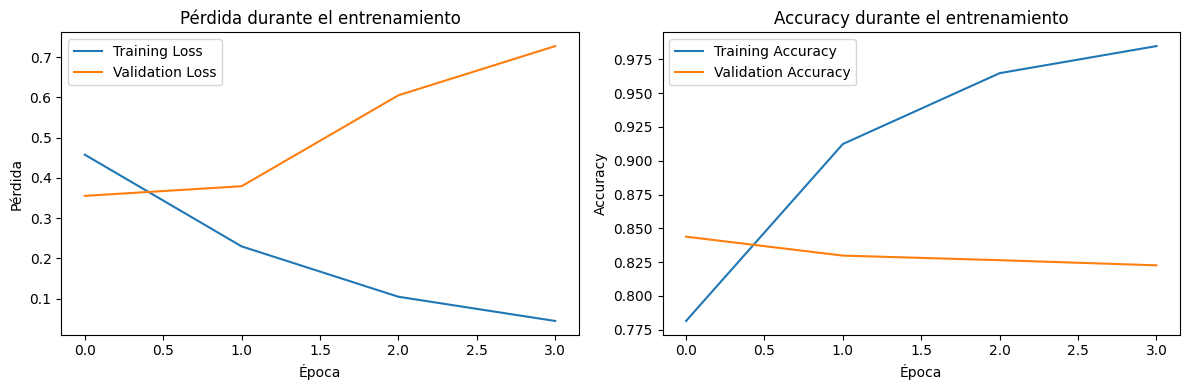

In [51]:

# 2. Extraer características para el conjunto de prueba (complementa tu extracción de entrenamiento)
test_features = extract_features_from_encoded(X_test)
test_features_array = np.array([[f[name] for name in feature_names] for f in test_features])
print('Características extraídas para el conjunto de prueba.')

# 3. Normalizar las características
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_array)
test_features_scaled = scaler.transform(test_features_array)
print('Características normalizadas.')

# 4. Definir el modelo LSTM híbrido
vocab_size = 50000  # Número de palabras únicas
embedding_dim = 128  # Dimensión de embeddings
lstm_units = 128     # Unidades en LSTM

# Input para secuencias de palabras
input_seq = Input(shape=(maxlen,), name='sequence_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_seq)
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)  # Primera LSTM bidireccional
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(lstm_units))(x)  # Segunda LSTM bidireccional
x = Dropout(0.3)(x)

# Input para características adicionales
input_features = Input(shape=(len(feature_names),), name='features_input')

# Concatenar salida de LSTM con features
combined = Concatenate()([x, input_features])

# Capas densas
dense = Dense(128, activation='relu')(combined)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.3)(dense)

# Capa de salida
output = Dense(1, activation='sigmoid')(dense)

# Compilar el modelo
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print('Entrenando el modelo...')
history = model.fit(
    [X_train, train_features_scaled], y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# 6. Evaluar el modelo
print('Evaluando el modelo...')
y_pred_prob = model.predict([X_test, test_features_scaled])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# 7. Visualizar historial de entrenamiento
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()